In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tqdm
import tensorflow as tf

In [45]:
postion=pd.read_csv('../input/racoon-detection/train_labels_.csv')

In [46]:
postion.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [47]:
postion.shape

(173, 8)

In [48]:
len(postion)

173

In [49]:
#loading data and resize it and collect it in one folder

trainpath = '../input/racoon-detection/Racoon Images/images/'
new_size=128    
X_train = []
y_train = []


for i in tqdm.tqdm(range(len(postion))): 
    orignal_image = cv2.imread(trainpath+postion.iloc[i,0])
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image , (new_size,new_size))
    X_train.append(resized_image)
print('image reading ...finished')
print('--------------------------------------------------')        


100%|██████████| 173/173 [00:37<00:00,  4.64it/s]

image reading ...finished
--------------------------------------------------


In [50]:
X_train=np.array(X_train)

In [51]:
X_train.shape

(173, 128, 128, 3)

In [52]:
img = cv2.imread(trainpath+str(postion.iloc[0,0]))
img.shape

(194, 259, 3)

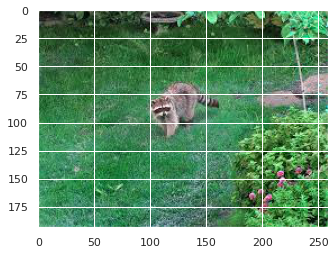

In [53]:
plt.imshow(img)

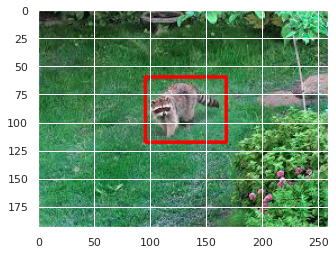

In [54]:
img=cv2.rectangle(img,(postion['xmin'][0],postion['ymin'][0]), (postion['xmax'][0],postion['ymax'][0]) , (255,0,0),2)
plt.imshow(img)   

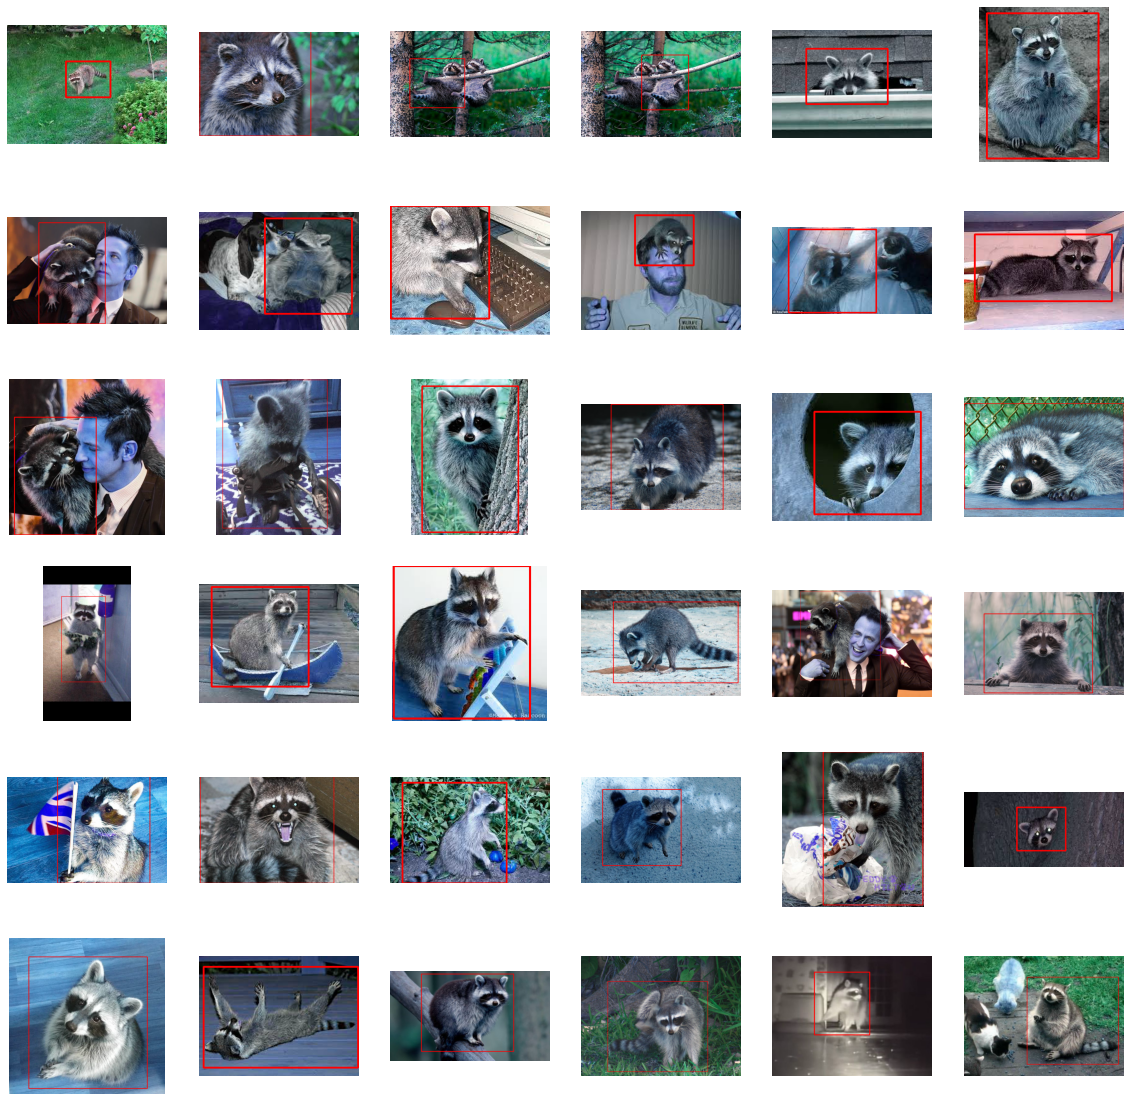

In [55]:
#showing training images with labels
plt.figure(figsize=(20,20))
for n , i in enumerate(range(36)) : 
    plt.subplot(6,6,n+1)
    img = cv2.imread(trainpath+str(postion.iloc[i,0]))
    img=cv2.rectangle(img,(postion['xmin'][i],postion['ymin'][i]), (postion['xmax'][i],postion['ymax'][i]) , (255,0,0),2)
    plt.imshow(img)   
    plt.axis('off')
    


In [56]:
postion=postion[["width","height","xmin","ymin","xmax","ymax"]]

postion["xmin"] = postion["xmin"] *new_size/postion["width"]
postion["xmax"] = postion["xmax"]*new_size /postion["width"]
postion["ymin"] = postion["ymin"] *new_size/postion["height"]
postion["ymax"] = postion["ymax"] *new_size/postion["height"]

In [57]:
#postion=postion.astype('int32')
postion.drop(['width','height'],axis=1,inplace=True)
postion.head()

,xmin,ymin,xmax,ymax
0,46.949807,39.587629,82.532819,77.855670
1,0.581818,0.296296,89.406061,127.703704
2,15.786667,34.240000,59.733333,92.800000
3,48.426667,29.760000,85.973333,95.360000
4,27.194139,22.832432,92.366300,87.870270


In [58]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

#optimizer
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [59]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [60]:
#callbacks
EarlyStop=EarlyStopping(patience=10,monitor='val_iou',restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_iou',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_iou',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [61]:
model=Sequential([
                    Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',input_shape=(new_size,new_size,3),kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),
    
                    Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),
    
                    Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),
    
    
                    Flatten(),
                    Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(4,activation='relu',kernel_initializer='glorot_normal')
                  
])



In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 40, 40, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 256)      

In [63]:
model.compile(optimizer=optimizer_adam,loss='mse',metrics=[IoU])



history=model.fit(X_train,postion,validation_split=0.1,epochs=100,batch_size=4,
                  steps_per_epoch=len(X_train)//4,
                  callbacks=callback, verbose=1)

Epoch 1/100
43/43 [==============================] - 2s 23ms/step - loss: 1709.5790 - IoU: 0.3261 - val_loss: 22899.3789 - val_IoU: 0.0944
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 515.3505 - IoU: 0.4953 - val_loss: 4193.7168 - val_IoU: 0.2147
Epoch 3/100
43/43 [==============================] - 1s 18ms/step - loss: 361.2958 - IoU: 0.5290 - val_loss: 1556.7168 - val_IoU: 0.3655
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 313.1858 - IoU: 0.5555 - val_loss: 538.6429 - val_IoU: 0.4872
Epoch 5/100
43/43 [==============================] - 1s 19ms/step - loss: 268.6839 - IoU: 0.6030 - val_loss: 483.8378 - val_IoU: 0.4405
Epoch 6/100
43/43 [==============================] - 1s 19ms/step - loss: 226.9222 - IoU: 0.6028 - val_loss: 430.8993 - val_IoU: 0.4973
Epoch 7/100
43/43 [==============================] - 1s 19ms/step - loss: 209.3374 - IoU: 0.6337 - val_loss: 487.9987 - val_IoU: 0.5112
Epoch 8/100
43/43 [========================

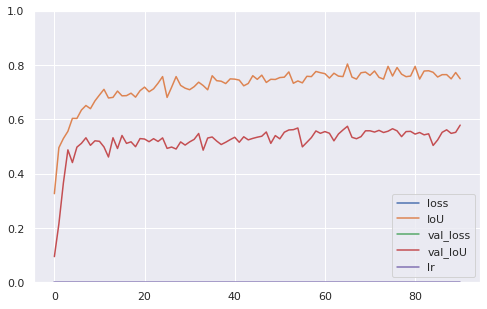

In [64]:
#plotting training values
import seaborn as sns
sns.set()


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

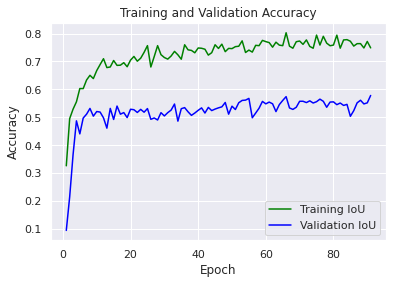

In [65]:

IoU = history.history['IoU']
val_IoU = history.history['val_IoU']
epochs = range(1, len(IoU) + 1)

#accuracy plot
plt.plot(epochs, IoU, color='green', label='Training IoU')
plt.plot(epochs, val_IoU, color='blue', label='Validation IoU')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [66]:
img=plt.imread('../input/racoon-detection/Racoon Images/images/raccoon-2.jpg')

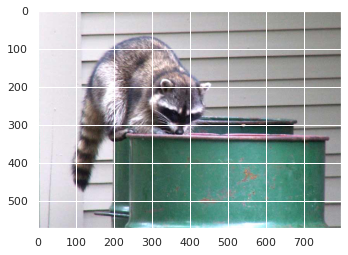

In [67]:
plt.imshow(img)

In [68]:
image_height, image_width, _ = img.shape
image = cv2.resize(img,(new_size,new_size))

In [69]:
image.shape

(128, 128, 3)

In [70]:
image=np.expand_dims(image,axis=0)

In [71]:
region = model.predict(image)[0]

In [72]:
region

array([ 14.97849 ,  10.008355,  80.49875 , 108.968735], dtype=float32)

In [73]:
x0 = int(region[0] * image_width / new_size) 
y0 = int(region[1] * image_height / new_size)
x1 = int((region[2]) * image_width / new_size)
y1 = int((region[3]) * image_height / new_size)

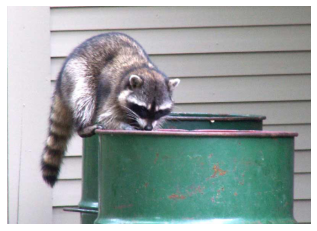

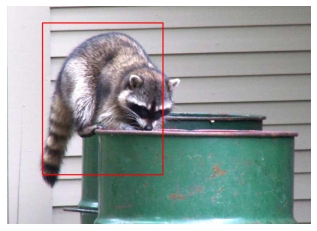

In [74]:
# Display the image
img=plt.imread('../input/racoon-detection/Racoon Images/images/raccoon-2.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()
# Create a Rectangle patch
cv2.rectangle(img,(x0, y0), ((x1 - x0) , (y1 - y0)) , (255,0,0),2)

# Add the patch to the Axes
plt.imshow(img)
plt.axis('off')
plt.show()